# Simulation of a longitudinal profile

In [1]:
#basic imports and ipython setup
%load_ext autoreload
%autoreload 2
import os
from scipy.interpolate import interp1d
from scipy.integrate import trapz
from collections import OrderedDict, defaultdict

import numpy as np
os.chdir('..')

#import solver related modules
from MCEq.core import MCEqRun
from mceq_config import config
#import primary model choices
import CRFluxModels as pm

In [2]:
interaction_models = (
    'EPOS-LHC',
    'QGSJet-II-04',
    'DPMJet-III',
    'DPMJet-III-2017.1',
    'SIBYLL-2.3.5',
    'SIBYLL-2.1',
    'QGSJet-01',
)

# E0, h_obs, theta_deg, density_model
experiments = {
    "auger": (1e10, 1425, 67, ("CORSIKA", ("BK_USStd", None))),
    "icecube": (1e8, 2835, 13, ("MSIS00_IC", ("SouthPole", "January"))),
}

In [3]:
mceq_data = {}
experiment_data = {}

for experiment in experiments:
    for interaction_model in interaction_models:
        for prim in ("proton", "iron"):
            key = experiment, interaction_model, prim
            if key in mceq_data: continue
            print "=== processing", experiment, interaction_model, prim, "==="
            data = mceq_data[key] = {}

            cr_energy, h_obs, theta_deg, density_model = experiments[experiment]
            
            cfg = dict(config)
            cfg["density_model"] = density_model
            cfg["h_obs"] = h_obs
            mceq_run = MCEqRun(
                interaction_model,
                primary_model=(pm.HillasGaisser2012, 'H3a'),
                theta_deg=theta_deg,
                **cfg
            )

            a = {"proton": 1, "iron": 56}[prim]
            mceq_run.set_single_primary_particle(
                cr_energy,
                {"proton": 14, "iron": 5626}[prim]
            )

            Xvec = np.arange(1, mceq_run.density_model.max_X, 5)

            mceq_run.solve(int_grid=Xvec, grid_var="X")

            x = mceq_run.e_grid
            if experiment not in experiment_data:
                experiment_data[experiment] = (
                    Xvec, mceq_run.density_model.s_lX2h(np.log(Xvec)), x
                )

            for label, parts in (
                    ("mu", ("total_mu-", "total_mu+")),
                    ("pi", ("pi-", "pi+")),
                    ("K", ("K-", "K+")),
                    ("p+n", ("p", "p-bar", "n", "n-bar"))
                ):
                number = np.empty_like(Xvec)
                avg_energy = np.empty_like(Xvec)
            
                for idx, X in enumerate(Xvec):
                    y = 0.0
                    for part in parts:
                        y += mceq_run.get_solution(part, 0, grid_idx=idx)
                    number[idx] = trapz(y, x)
                    avg_energy[idx] = trapz(x * y, x) / number[idx]

                data["%s_profile" % label] = (number, avg_energy)


=== processing auger EPOS-LHC proton ===
InteractionYields::_load(): Looking for /Users/hdembins/miniconda2/MCEq/data/EPOSLHC_yields_compact_ledpm.bz2
DecayYields:_load():: Loading file /Users/hdembins/miniconda2/MCEq/data/decays_v1_compact.ppd

Hadrons and stable particles:

"gamma", "p", "p-bar", "n", "n-bar"

Mixed:

"pi-", "pi+", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "K0S"

Resonances:



Leptons:

"e-", "nue", "numu", "nutau", "antinutau", "antinumu", "antinue", "e+", 
"mu-", "mu+"

Aliases:
"obs_numu", "obs_nutau", "pr_antinutau", "pr_antinumu", "pr_antinue", "obs_antinue", "k_nue", "k_numu", 
"k_nutau", "pi_antinutau", "pi_antinue", "pi_antinumu", "pi_nue", "pi_numu", "pi_nutau", "k_antinutau", 
"k_antinumu", "k_antinue", "obs_nue", "pr_nue", "pr_numu", "pr_nutau", "obs_antinutau", "obs_antinumu", 
"k_mu-", "obs_mu-", "pr_mu+", "pi_mu+", "pi_mu-", "pr_mu-", "obs_mu+", "k_mu+"

Total number of species: 55
MCEqRun::set_interaction_model():  EPOSLHC
InteractionYields:set_int

# Plot with matplotlib

In [4]:
%matplotlib nbagg
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["font.size"] = 20
rcParams["figure.figsize"] = (7, 6)

def model_color(name):
    model_colors = {"EPOS-LHC": "k",
                    "SIBYLL-2.3": "b",
                    "SIBYLL-2.1": "m", 
                    "DPMJet" : "g",
                    "QGSJet" : "r",
                    "QGSJet-01": "0.5"}
    for k,v in model_colors.items():
        if name.startswith(k):
            return v

def model_linestyle(name):
    if name in ("EPOS-LHC", "SIBYLL-2.3.5", "DPMJet-III-2017.1", "QGSJet-II-04"):
        return "-"
    else:
        return ":"

<IPython.core.display.Javascript object>


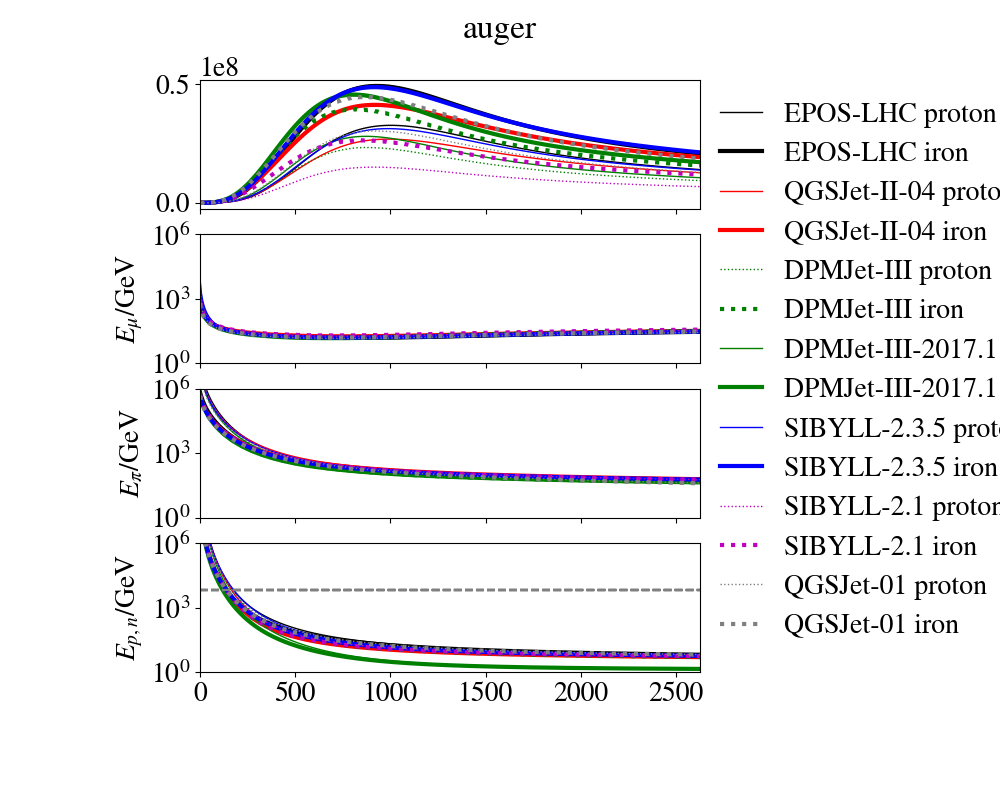

<IPython.core.display.Javascript object>


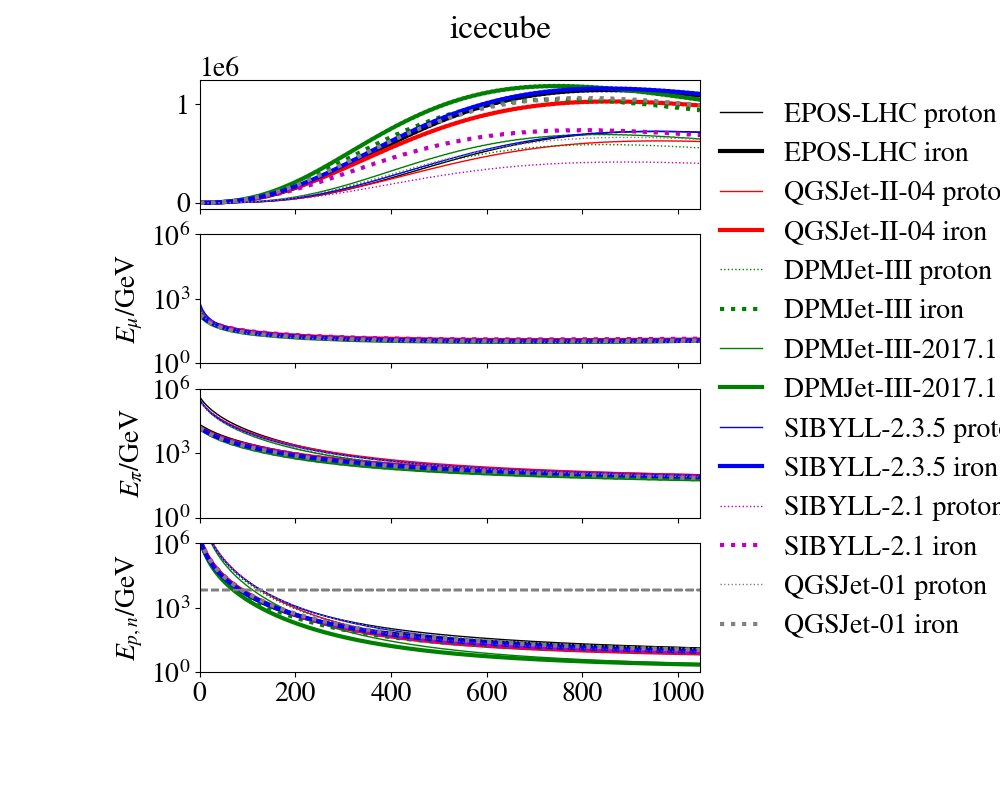

In [5]:
# details
for experiment in experiments:
    X, h, energy = experiment_data[experiment]
    fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    plt.subplots_adjust(right=0.7)
    plt.suptitle(experiment)
    for model in interaction_models:
        for prim in ("proton", "iron"):
            key = (experiment, model, prim)
            if key not in mceq_data: continue
            d = mceq_data[key]
            number, avg_energy = d["mu_profile"]
            plt.sca(ax[0])
            ls = model_linestyle(model)
            col = model_color(model)
            lw=3 if prim == "iron" else 1
            plt.plot(X, number, ls, color=col, lw=lw, label=model + " " + prim)
            plt.sca(ax[1])
            plt.plot(X, avg_energy, ls, color=col, lw=lw)
            plt.ylabel(r"$E_\mu / \mathrm{GeV}$")
            plt.semilogy()
            plt.ylim(1, 1e6)
            plt.sca(ax[2])
            number, avg_energy = d["pi_profile"]
            plt.plot(X, avg_energy, ls, color=col, lw=lw)
            plt.ylabel(r"$E_\pi / \mathrm{GeV}$")
            plt.semilogy()
            plt.ylim(1, 1e6)
            plt.sca(ax[3])
            number, avg_energy = d["p+n_profile"]
            plt.plot(X, avg_energy, ls, color=col, lw=lw)
            plt.ylabel(r"$E_{p,n} / \mathrm{GeV}$")
            plt.axhline(6500, ls="--", color="0.5")
            plt.semilogy()
            plt.ylim(1, 1e6)
    plt.sca(ax[0])
    plt.legend(bbox_to_anchor=(0.8, 0.0, 1.0, 1.0))

<IPython.core.display.Javascript object>


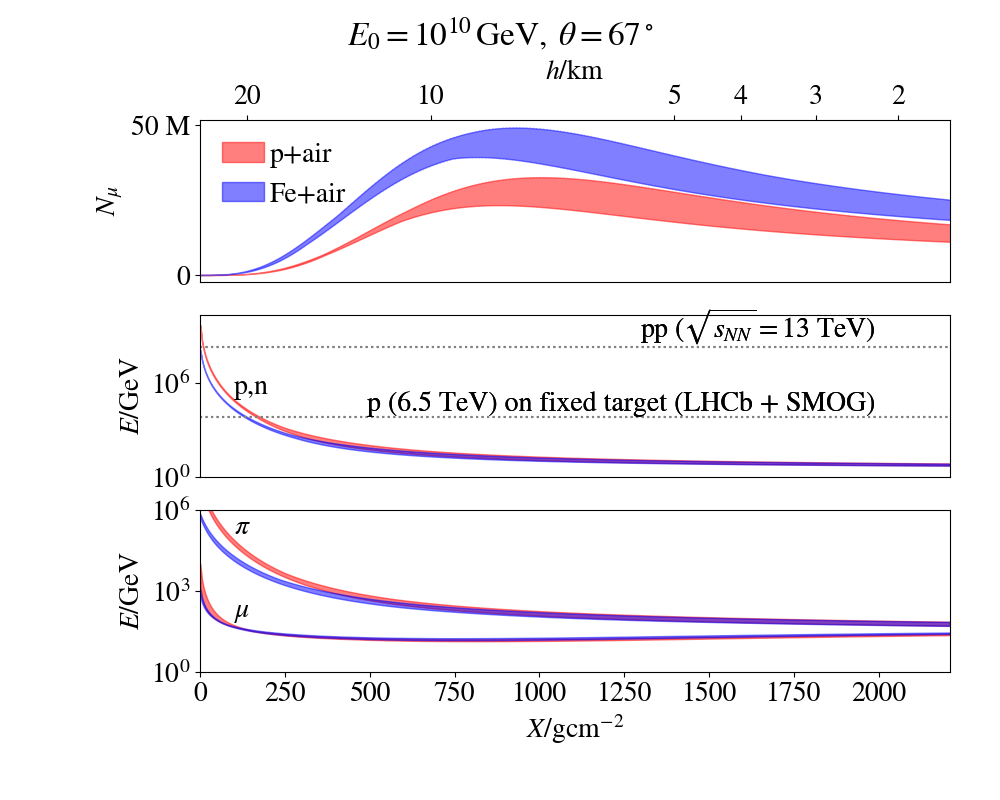

<IPython.core.display.Javascript object>


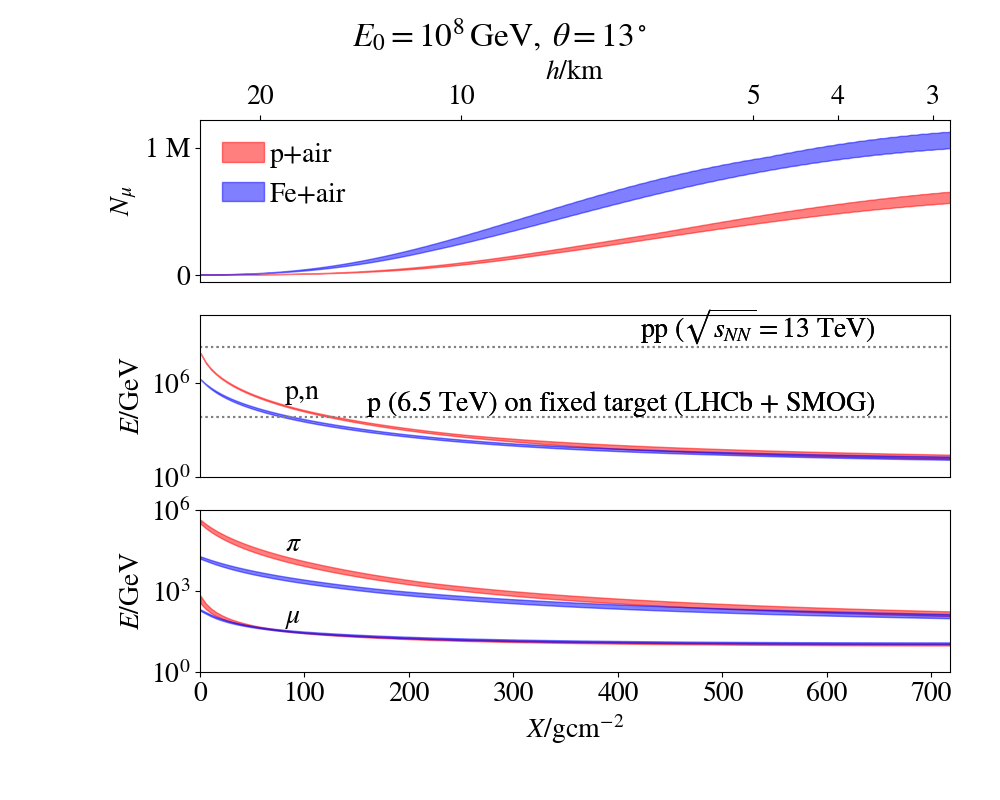

In [13]:
# propaganda
avg_models = (
    'EPOS-LHC',
    'QGSJet-II-04',
    'SIBYLL-2.3.5',
    'DPMJet-III',
#    'QGSJet01',
)

from scipy.interpolate import interp1d

mass_nucleon = 0.936 # GeV

energy_smog = 6500
energy_pp = 13e3 ** 2 / mass_nucleon
energy_po = 9.2e3 ** 2 / mass_nucleon

x_int_p_air = 90.1 # g cm-2
x_int_Fe_air = x_int_p_air / 56 ** 0.3

from matplotlib.ticker import EngFormatter

for experiment in experiments:
    X, h, energy = experiment_data[experiment]
    h = h / 1e5 # cm to km
    h2X = interp1d(h, X)
    e0, h_obs, theta, _ = experiments[experiment] 
    h_obs = h_obs / 1e3 # m to km
    
    x_smog = []
    x_o = []
    
    fig, ax = plt.subplots(3, 1, figsize=(10, 8))
    plt.subplots_adjust(right=0.95, top=0.85)
    plt.suptitle(r"$E_0 = 10^{%g}\,\mathrm{GeV},\;\theta = %.0f^\circ$" % (np.log10(e0), theta))
    plt.sca(ax[0])
    plt.tick_params(bottom="off", labelbottom="off", labeltop="on", top="on")
    heights = np.array((h[-1], 1, 2, 3, 4, 5, 10, 20), dtype=float)
    heights = heights[heights < np.max(h)]
    plt.xticks(h2X(heights), ["%.0f" % _ for _ in heights])
    plt.title(r"$h / \mathrm{km}$", y=1.2)
    for a in ax[1:-1]:
        plt.sca(a)
        plt.tick_params(bottom="off", top="off", labelbottom="off", labeltop="off")

    for a in ax:
        a.set_xlim(xmax=h2X(h_obs))
    ax[0].yaxis.set_major_formatter(EngFormatter())

    for prim in ("proton", "iron"):
        col = "r" if prim == "proton" else "b"
        mu_number = []
        average = defaultdict(lambda:[])
        for model in avg_models:
            key = (experiment, model, prim)
            if key not in mceq_data: continue
            d = mceq_data[key]
            number = d["mu_profile"][0]
            mu_number.append(number)
            for t in ("mu", "pi", "p+n"):
                average[t].append(d[t + "_profile"][1])

        plt.sca(ax[0])
        vmin, vmax = np.min(mu_number, axis=0), np.max(mu_number, axis=0)
        plt.fill_between(X, vmin, vmax, edgecolor=col, facecolor=col, alpha=0.5,
                         label={"proton": "p+air", "iron": "Fe+air"}[prim])
        plt.ylabel(r"$N_\mu$")
        plt.legend(loc="upper left", handletextpad=0.2)
        
        for t in ("mu", "pi", "p+n"):
            plt.sca(ax[1 if t in ("p+n") else 2])
            a = average[t]
            vmin, vmax = np.min(a, axis=0), np.max(a, axis=0)
            if t == "p+n":
                for y in (vmin, vmax):
                    for xl, energy in ((x_smog, energy_smog), (x_o, energy_o)): 
                        i = np.argmin(np.abs(y - energy))
                        xl.append(X[i])
            
            plt.fill_between(X, vmin, vmax, edgecolor=col, facecolor=col, alpha=0.5)
            if prim == "proton":
                i = np.argmin(np.abs(X  - (100 if experiment == "auger" else 80)))
                plt.text(X[i], vmax[i], ("$\%s$" % t) if t != "p+n" else "p,n", va="bottom")
            plt.semilogy()
            plt.ylim(1, 1e6)
            plt.ylabel(r"$E / \mathrm{GeV}$")

        plt.sca(ax[1])
        plt.axhline(energy_smog, ls=":", color="0.5")
        plt.text(0.9, energy_smog, "p (6.5 TeV) on fixed target (LHCb + SMOG)", va="bottom", ha="right",
                 transform=ax[1].get_yaxis_transform())
        plt.axhline(energy_pp, ls=":", color="0.5")
        plt.text(0.9, energy_pp, "pp ($\sqrt{s_{NN}} = 13$ TeV)", va="bottom", ha="right",
                transform=ax[1].get_yaxis_transform())
#         plt.axhline(energy_po, ls=":", color="0.5")
#         plt.text(0.9, energy_po, "pO ($\sqrt{s_{NN}} = 9.2$ TeV)", va="bottom", ha="right",
#                 transform=ax[1].get_yaxis_transform())
        plt.ylim(ymax=1e2 * energy_o)

    plt.sca(ax[-1])
    plt.xlabel(r"$X / \mathrm{g cm^{-2}}$")
    plt.savefig("long_profile_%s.pdf" % experiment)